In [1]:
# for reduction of computation time:
max_events = 100

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from konsta_cta.readdata import FileReader

from ctapipe.calib.camera.r1 import HESSIOR1Calibrator
from ctapipe.calib.camera.dl0 import CameraDL0Reducer
from ctapipe.calib.camera import CameraDL1Calibrator

r1cal = HESSIOR1Calibrator()
dl0cal = CameraDL0Reducer()
dl1cal = CameraDL1Calibrator()

def calibrator(event):
    r1cal.calibrate(event)
    dl0cal.reduce(event)
    dl1cal.calibrate(event)
    
from ctapipe.calib import CameraCalibrator

Problem here: for r1 calibration only CameraR1CalibratorFactory possible.  
How to select HESSIOR1Calibrator??  
`from ctapipe.calib import CameraCalibrator`

# Collect list of files

If `file_list` not passed directly to FileReader collect from `directory`

In [3]:
protons = FileReader("proton", directory="~/CTAPIPE/", max_events=max_events)
electrons = FileReader("electron", directory="~/CTAPIPE/", max_events=max_events)
gamma_cone = FileReader("gamma_cone", directory="~/CTAPIPE/", max_events=max_events)
gamma_onSource = FileReader("gamma_onSource", directory="~/CTAPIPE/", max_events=max_events)

Number of files to read: 2 for datatype proton
Number of files to read: 2 for datatype electron
Number of files to read: 2 for datatype gamma_cone
Number of files to read: 2 for datatype gamma_onSource


### Read the files

Possibility to to this via generator or all together from list (maybe conflict with ctapipe??)

In [4]:
prot_gen = protons.files_as_generator()
elec_gen = electrons.files_as_generator()
ga_co_gen = gamma_cone.files_as_generator()
ga_on_gen = gamma_onSource.files_as_generator()

In [5]:
for particle in [prot_gen, elec_gen, ga_co_gen, ga_on_gen]:
    next(particle)

Now opening proton file 1
Now opening electron file 1
Now opening gamma_cone file 1
Now opening gamma_onSource file 1


---------
---------
Source files now accesable via `particle.source`.

Select the first event.

In [6]:
for event in gamma_cone.source:
    break
event

ctapipe.io.containers.DataContainer:
                          r0.*: Raw Data
                          r1.*: R1 Calibrated Data
                         dl0.*: DL0 Data Volume Reduced Data
                         dl1.*: DL1 Calibrated image
                         dl2.*: Reconstructed Shower Information
                          mc.*: Monte-Carlo data
                    mcheader.*: Monte-Carlo run header data
                        trig.*: central trigger information
                         count: number of events processed
                        inst.*: instrumental information (deprecated
                   pointing[*]: Telescope pointing positions

The hessio files are filled only to r0. Datalevel r1, dl0 an dl1 are obtained with reduction and calibration of the images.

### Calibration

Performing the calibration of the images from r0 $\rightarrow$ dl1. Important: calibrator for r1 must fit the simulation file. In this case: `HESSIOR1Calibrator`

`CameraCalibrator` not applyable because `HESSIOR1Calibrator` not selectable.

The calibration process returns calibrated camera images in `pe` for dl1

In [7]:
calibrator(event)
image1 = event.dl1.tel[30].image
image1 = np.reshape(image1, [np.shape(image1)[1]])

In [8]:
cal = CameraCalibrator()
cal.calibrate(event)

image2 = event.dl1.tel[30].image
image2 = np.reshape(image2, [np.shape(image2)[1]])

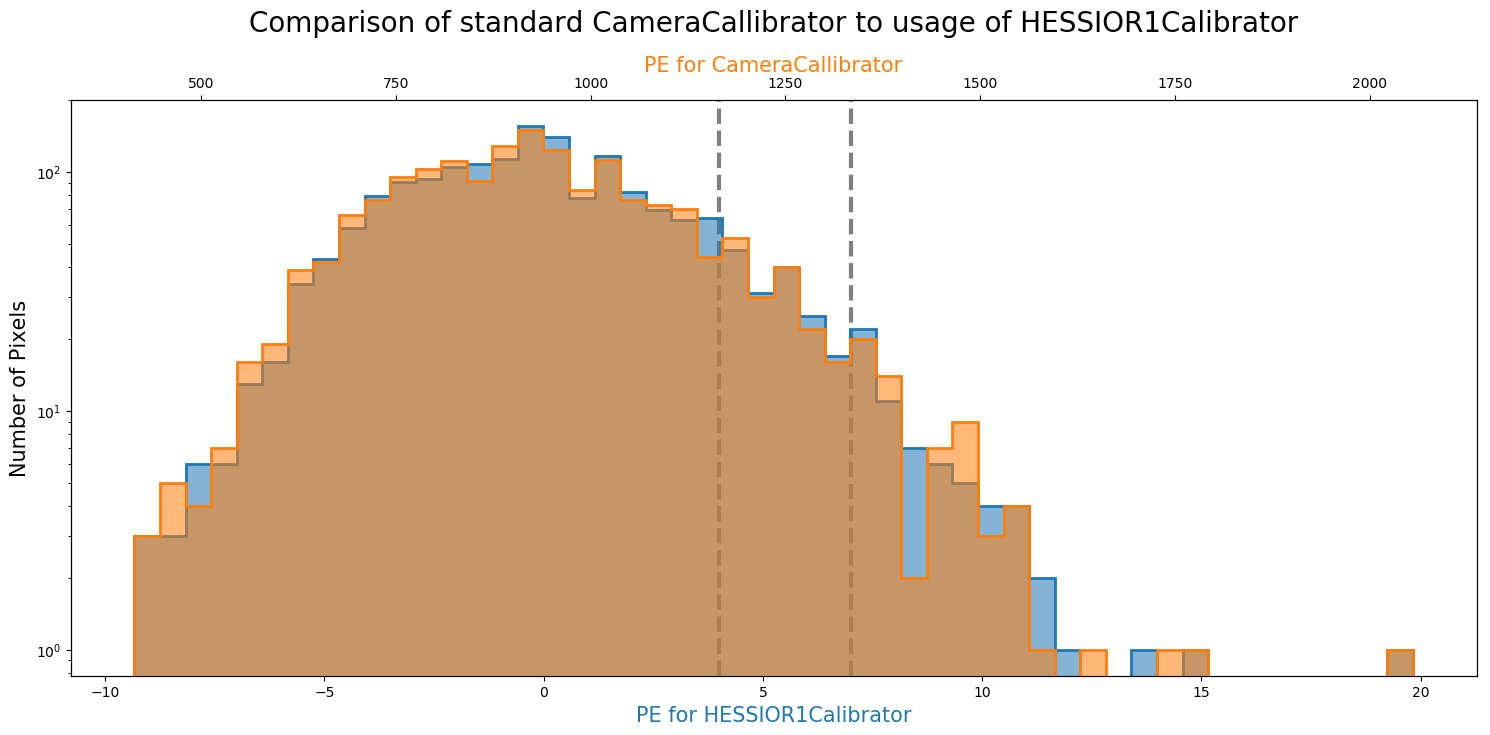

In [23]:
fig = plt.figure(figsize=[15,7])
ax1 = fig.add_subplot(111)
ax1.hist(image1, alpha=0.55, bins=50, color='C0', zorder=1)
ax1.hist(image1, alpha=1, bins=50, color='C0', histtype='step', stacked=True, linewidth=2, zorder=1)

ax2 = ax1.twiny()
ax2.hist(image2, alpha=0.55, bins=50, color='C1', zorder=1)
ax2.hist(image2, alpha=1, bins=50, color='C1', histtype='step', stacked=True, linewidth=2, zorder=1)

ax1.axvline(7, color='grey', linewidth=3, linestyle='--', zorder=0)
ax1.axvline(4, color='grey', linewidth=3, linestyle='--', zorder=0)

ax1.set_xlabel("PE for HESSIOR1Calibrator", color='C0', fontsize=15)
ax2.set_xlabel("PE for CameraCallibrator", color='C1', fontsize=15)

ax1.set_ylabel('Number of Pixels', fontsize=15)

title = "Comparison of standard CameraCallibrator to usage of HESSIOR1Calibrator"
plt.text(0.5, 1.12, title,
         horizontalalignment='center',
         fontsize=20,
         transform = ax2.transAxes)
plt.style.use(['default'])
ax1.semilogy()

plt.tight_layout()

In [ ]:
#